In [2]:
import numpy as np
import pandas as pd
from astro.config import Config
from typing import Optional

from astro.load import (
    load_cell_props,
    load_mice,
)

from astro.constants import SESSIONS, SESSION_MAPPER
import openpyxl.styles as xl_styles

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from IPython.display import display
from dataclasses import dataclass

In [3]:
config = Config.from_env()

data_dir, output_dir = config.data_dir, config.derived_data_dir
output_dir.mkdir(exist_ok=True)

In [44]:
@dataclass
class DatasetOutput:
    """Class for storing output of analysis."""

    neuron_fact_table: Optional[pd.DataFrame] = None
    neuron_presence_by_session: Optional[pd.DataFrame] = None
    neuron_count_by_session: Optional[pd.DataFrame] = None
    neuron_session_overlap: Optional[pd.DataFrame] = None
    neuron_session_overlap_propotion: Optional[pd.DataFrame] = None
    plot_count_per_session: Optional[pd.DataFrame] = None


output = DatasetOutput()

## Make Neuron Fact Table

- One row for each neuron in the experiment with the mouse in which it was recorded and the group of that mouse

In [45]:
# load raw data

df_mice = load_mice(data_dir).loc[lambda x: x.group != "VEH-VEH"]

display(df_mice.head(3))

print(f"\nLoading neuron properties files from sessions: {SESSIONS}")
neuron_props = {}
for session in SESSIONS:
    neuron_props[session] = load_cell_props(data_dir, session_name=session)

df_props = pd.concat(
    [df.assign(session=session) for session, df in neuron_props.items()]
)

display(df_props.sample(3))

,mouse_name,group
1,AS-Gq-GRIN-22,VEH-CNO
3,AS-Gq-GRIN-24,CNO-VEH
4,AS-Gq-GRIN-25,CNO-VEH



Loading neuron properties files from sessions: ['hab-cage', 'hab-tone', 'cond', 'ret', 'ext', 'diff-ret', 'late-ret', 'renewal']


,status,centroid_x,centroid_y,num_components,size,mouse_name,cell_id,session
4,accepted,180,45,1,9.21954,AS-Gq-hSyn-5,2324,hab-cage
47,accepted,173,147,1,8.24621,AS-Gq-hSyn-12,1523,ext
76,accepted,202,124,1,9.21954,AS-Gq-GRIN-27,836,ext


In [46]:
# merge data and select columns

df = df_props.merge(df_mice[["mouse_name", "group"]])

neurons_fact_table = df.loc[
    :, ["cell_id", "mouse_name", "group", "centroid_x", "centroid_y", "size"]
]


display(neurons_fact_table.sample(3))

output.neuron_fact_table = neurons_fact_table

,cell_id,mouse_name,group,centroid_x,centroid_y,size
1460,565,AS-Gq-GRIN-25,CNO-VEH,158,134,9.48683
3925,2115,AS-Gq-hSyn-18,CNO-VEH,204,119,10.77030
4394,2497,AS-Gq-hSyn-6,CNO-VEH,214,141,10.44030


### Get neuron presence on each session

- One row for each neuron
- One column for each session
- 1 if the neuron was recorded in that session, 0 otherwise

In [47]:
neuron_presence = (
    df.pivot_table(
        index=["group", "mouse_name", "cell_id"],
        columns="session",
        values="num_components",
    )
    .fillna(0)
    .loc[:, SESSIONS]
    .reset_index()
    .loc[:, ["cell_id", "mouse_name", "group", *SESSIONS]]
    .rename(columns=SESSION_MAPPER)
    .loc[lambda x: x.group != "VEH-VEH"]
)

output.neuron_presence_by_session = neuron_presence

display(neuron_presence.sample(3))

session,cell_id,mouse_name,group,Hab-Cage,Hab-Tone,Conditioning,Retrieval,Extinction,Ext-Ret,Late-Ret,Renewal
1065,761,AS-Gq-GRIN-27,VEH-CNO,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
245,603,AS-Gq-GRIN-25,CNO-VEH,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1208,1097,AS-Gq-GRIN-30,VEH-CNO,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


### Neuron Count Per Session

In [48]:
session_neuron_count = (
    df.pivot_table(
        index=["group", "mouse_name", "cell_id"],
        columns="session",
        values="num_components",
    )
    .fillna(0)
    .loc[:, SESSIONS]
    .rename(columns=SESSION_MAPPER)
    .reset_index(level=0)
    .groupby("group")
    .sum()
    .astype(int)
)

output.neuron_count_by_session = session_neuron_count
display(session_neuron_count)

session,Hab-Cage,Hab-Tone,Conditioning,Retrieval,Extinction,Ext-Ret,Late-Ret,Renewal
group,,,,,,,,
CNO-VEH,321,420,382,345,483,326,408,375
VEH-CNO,274,407,295,340,407,305,282,320


## Number of Coregistered Cells For Each Session Combination (Group-wise)

- One row for each group on each session
- One column for each session
- Values are the number of neurons that were recorded in both sessions

In [49]:
from itertools import combinations, permutations
from functools import partial
from typing import Callable


def num_cells_coreg(cells1, cells2, norm=False):

    intersection = np.intersect1d(cells1, cells2).size
    if norm:
        union = np.union1d(cells1, cells2).size
        return intersection / union
    else:
        return intersection


def get_similarity_by_group(
    df, similarity_func: Callable[[tuple[np.ndarray, np.ndarray]], np.number]
) -> pd.DataFrame:
    out = []
    for group in df["group"].unique():
        g = df.loc[lambda x: x["group"] == group].groupby(["session"])

        for (session1, df1), (session2, df2) in permutations(g, 2):
            # print(df1["cell_id"].values, df2["cell_id"].values )
            num_overlab = similarity_func(df1["cell_id"].values, df2["cell_id"].values)
            session1_name = SESSION_MAPPER[session1[0]]
            session2_name = SESSION_MAPPER[session2[0]]

            comb = f"{session1_name}-{session2_name}"
            out.append(
                dict(
                    group=group,
                    session1=session1_name,
                    session2=session2_name,
                    comb=comb,
                    num_overlab=num_overlab,
                )
            )
    df_overlap = pd.DataFrame(out)
    return df_overlap


df = df_props.merge(df_mice[["mouse_name", "group"]])
df_overlap = get_similarity_by_group(df, num_cells_coreg)

df_overlap = (
    df_overlap.pivot(
        index=["session1", "group"],
        columns=["session2"],
        values=["num_overlab"],
    )
    .fillna(0)
    .astype(int)
)

output.neuron_session_overlap = df_overlap
display(df_overlap)

num_overlab                                       \
session2             Conditioning Ext-Ret Extinction Hab-Cage Hab-Tone   
session1     group                                                       
Conditioning CNO-VEH            0     169        243      192      244   
             VEH-CNO            0     114        157      132      188   
Ext-Ret      CNO-VEH          169       0        216      168      175   
             VEH-CNO          114       0        140      111      142   
Extinction   CNO-VEH          243     216          0      196      246   
             VEH-CNO          157     140          0      135      188   
Hab-Cage     CNO-VEH          192     168        196        0      215   
             VEH-CNO          132     111        135        0      184   
Hab-Tone     CNO-VEH          244     175        246      215        0   
             VEH-CNO          188     142        188      184        0   
Late-Ret     CNO-VEH          186     152        235      156      197   
             VEH-CNO          113     109        134      106      142   
Renewal      CNO-VEH          167     160        210      156      174   
             VEH-CNO          126     112        139      117      162   
Retrieval    CNO-VEH          185     168        237      169      187   
             VEH-CNO          163     138        175      148      207   

                                                 
session2             Late-Ret Renewal Retrieval  
session1     group                               
Conditioning CNO-VEH      186     167       185  
             VEH-CNO      113     126       163  
Ext-Ret      CNO-VEH      152     160       168  
             VEH-CNO      109     112       138  
Extinction   CNO-VEH      235     210       237  
             VEH-CNO      134     139       175  
Hab-Cage     CNO-VEH      156     156       169  
             VEH-CNO      106     117       148  
Hab-Tone     CNO-VEH      197     174       187  
             VEH-CNO      142     162       207  
Late-Ret     CNO-VEH        0     189       167  
             VEH-CNO        0     146       126  
Renewal      CNO-VEH      189       0       162  
             VEH-CNO      146       0       133  
Retrieval    CNO-VEH      167     162         0  
             VEH-CNO      126     133         0

In [50]:
normalized_coreg = partial(num_cells_coreg, norm=True)

df = df_props.merge(df_mice[["mouse_name", "group"]])
df_overlap = get_similarity_by_group(df, normalized_coreg)

df_overlap = (
    df_overlap.pivot(
        index=["session1", "group"],
        columns=["session2"],
        values=["num_overlab"],
    )
    .fillna(0)
    .mul(100)
    .round(1)
)
display(df_overlap)

output.neuron_session_overlap_propotion = df_overlap

num_overlab                                       \
session2             Conditioning Ext-Ret Extinction Hab-Cage Hab-Tone   
session1     group                                                       
Conditioning CNO-VEH          0.0    31.5       39.4     38.0     44.4   
             VEH-CNO          0.0    23.9       29.3     30.9     37.2   
Ext-Ret      CNO-VEH         31.5     0.0       36.7     35.4     31.1   
             VEH-CNO         23.9     0.0       25.0     24.3     25.4   
Extinction   CNO-VEH         39.4    36.7        0.0     32.6     38.0   
             VEH-CNO         29.3    25.0        0.0     25.2     30.5   
Hab-Cage     CNO-VEH         38.0    35.4       32.6      0.0     41.7   
             VEH-CNO         30.9    24.3       25.2      0.0     37.8   
Hab-Tone     CNO-VEH         44.4    31.1       38.0     41.7      0.0   
             VEH-CNO         37.2    25.4       30.5     37.8      0.0   
Late-Ret     CNO-VEH         31.3    26.5       36.4     27.8     31.9   
             VEH-CNO         24.9    23.4       24.7     24.3     26.5   
Renewal      CNO-VEH         28.8    30.1       33.0     29.5     28.7   
             VEH-CNO         26.2    22.3       24.0     25.1     29.1   
Retrieval    CNO-VEH         34.5    33.7       40.5     34.5     32.9   
             VEH-CNO         35.1    27.8       31.1     32.5     38.9   

                                                 
session2             Late-Ret Renewal Retrieval  
session1     group                               
Conditioning CNO-VEH     31.3    28.8      34.5  
             VEH-CNO     24.9    26.2      35.1  
Ext-Ret      CNO-VEH     26.5    30.1      33.7  
             VEH-CNO     23.4    22.3      27.8  
Extinction   CNO-VEH     36.4    33.0      40.5  
             VEH-CNO     24.7    24.0      31.1  
Hab-Cage     CNO-VEH     27.8    29.5      34.5  
             VEH-CNO     24.3    25.1      32.5  
Hab-Tone     CNO-VEH     31.9    28.7      32.9  
             VEH-CNO     26.5    29.1      38.9  
Late-Ret     CNO-VEH      0.0    32.6      29.0  
             VEH-CNO      0.0    32.9      26.0  
Renewal      CNO-VEH     32.6     0.0      29.6  
             VEH-CNO     32.9     0.0      25.7  
Retrieval    CNO-VEH     29.0    29.6       0.0  
             VEH-CNO     26.0    25.7       0.0

### Plot Neuron Session Count

In [51]:
CategoricalPalette = list[str] | mcolors.Colormap


def grouped_horizontal_barplot(
    df: pd.DataFrame,
    group_col: str,
    bar_type_col: str,
    value_col: str,
    group_order: list[str] | None = None,
    bar_type_order: list[str] | None = None,
    ax: plt.Axes = None,
    palette: CategoricalPalette | None = None,
    legend: bool = True,
    group_spacing_factor: float = 1.0,
) -> plt.Axes:
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    if isinstance(palette, mcolors.Colormap):
        n_colors = df[group_col].nunique()
        palette = palette(np.linspace(0, 1, n_colors))

    if palette is None:
        palette = sns.color_palette("tab10", n_colors=df[group_col].nunique())

    if group_order is None:
        group_order = df[group_col].unique().tolist()

    if bar_type_order is None:
        bar_type_order = df[bar_type_col].unique().tolist()

    num_groups = len(group_order)
    num_bartypes = len(bar_type_order)

    for idx, group in enumerate(group_order):
        sub_df = df[df[group_col] == group]
        color = palette[idx]

        for jdx, bartype in enumerate(bar_type_order):
            value = sub_df[sub_df[bar_type_col] == bartype][value_col].values[0]
            position = idx * (num_bartypes * group_spacing_factor) + jdx
            ax.barh(position, value, color=color, label=f"{group}" if jdx == 0 else "")

    # Adjust y-tick positions based on bar type order and group spacing factor
    ytick_positions = [
        idx * (num_bartypes * group_spacing_factor) + jdx
        for idx in range(num_groups)
        for jdx in range(num_bartypes)
    ]
    ytick_labels = bar_type_order * num_groups
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels(ytick_labels)

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(dict.fromkeys(labels))
        unique_handles = [handles[labels.index(lab)] for lab in unique_labels]
        ax.legend(unique_handles, unique_labels, title=group_col)

    return ax

,group,session,num_neurons
0,CNO-VEH,Conditioning,380
1,CNO-VEH,Ext-Ret,325
2,CNO-VEH,Extinction,480


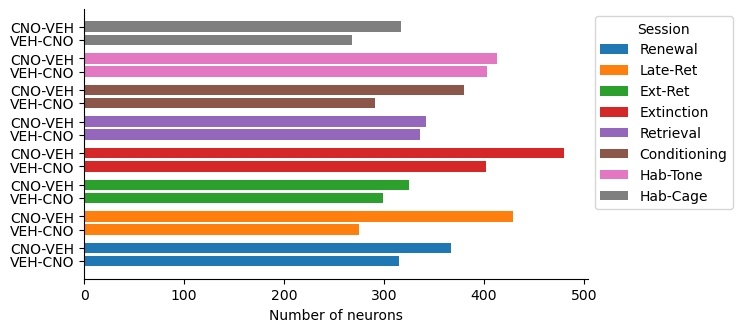

In [52]:
df_counts_plot = (
    df.groupby(["group", "session"])
    .count()
    .reset_index()
    .rename(columns=dict(cell_id="num_neurons"))
    .assign(session=lambda x: x.session.map(SESSION_MAPPER))
    .loc[:, ["group", "session", "num_neurons"]]
)

display(df_counts_plot.head(3))


f, ax = plt.subplots(figsize=(6.5, 3.5))

ax = grouped_horizontal_barplot(
    df=df_counts_plot,
    group_col="session",
    bar_type_col="group",
    value_col="num_neurons",
    bar_type_order=[
        "VEH-CNO",
        "CNO-VEH",
        # "VEH-VEH",
    ],
    group_order=list(SESSION_MAPPER.values())[::-1],
    group_spacing_factor=1.2,
    ax=ax,
)
ax.set_xlabel("Number of neurons")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="Session")
sns.despine(ax=ax)

output.plot_count_per_session = f

### Save Data

In [53]:
import openpyxl
from io import BytesIO


def bold_headers(sheet: openpyxl.worksheet.worksheet.Worksheet):
    for cell in sheet["1:1"]:
        cell.font = xl_styles.Font(bold=True)
    return sheet


with pd.ExcelWriter(output_dir / "dataset.xlsx", engine="openpyxl") as writer:
    # write data
    output.neuron_fact_table.to_excel(
        writer, sheet_name="neuron_fact_table", index=False
    )
    output.neuron_presence_by_session.to_excel(
        writer, sheet_name="neuron_presence_by_session", index=False
    )
    output.neuron_count_by_session.to_excel(
        writer, sheet_name="neuron_count_by_session", index=False
    )
    output.neuron_session_overlap.to_excel(
        writer, sheet_name="neuron_session_overlap", index=True
    )
    output.neuron_session_overlap_propotion.to_excel(
        writer, sheet_name="neuron_session_overlap_propotion", index=True
    )

    workbook = writer.book
    for sheet in workbook.worksheets:
        bold_headers(sheet)

    # write plots
    plot_buffer = BytesIO()
    output.plot_count_per_session.savefig(
        plot_buffer, format="png", dpi=300, bbox_inches="tight"
    )
    plot_buffer.seek(0)

    plot_sheet = workbook.create_sheet("neuron_count_plot")
    plot_sheet.add_image(openpyxl.drawing.image.Image(plot_buffer), "A1")

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
